### Running API for getting data set

In [1]:
# making parameters
# Currency and Time Frame
params = {
    "count": 3000,
    "granularity": 'H1'
}

In [2]:
# Calling the API
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
#import mplfinance as mpf
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
client = oandapyV20.API(access_token="3e0f7f10c6e7badcfabbf14ec0ea6e0f-f46e39153b94a3659e539e630ae9112a")

r = instruments.InstrumentsCandles(instrument="EUR_USD", params=params)
db = client.request(r)
print(r.response)


{'instrument': 'EUR_USD', 'granularity': 'H1', 'candles': [{'complete': True, 'volume': 396, 'time': '2020-01-17T21:00:00.000000000Z', 'mid': {'o': '1.10927', 'h': '1.10929', 'l': '1.10892', 'c': '1.10902'}}, {'complete': True, 'volume': 345, 'time': '2020-01-19T22:00:00.000000000Z', 'mid': {'o': '1.10930', 'h': '1.10943', 'l': '1.10894', 'c': '1.10907'}}, {'complete': True, 'volume': 422, 'time': '2020-01-19T23:00:00.000000000Z', 'mid': {'o': '1.10906', 'h': '1.10948', 'l': '1.10892', 'c': '1.10946'}}, {'complete': True, 'volume': 585, 'time': '2020-01-20T00:00:00.000000000Z', 'mid': {'o': '1.10948', 'h': '1.10986', 'l': '1.10927', 'c': '1.10930'}}, {'complete': True, 'volume': 634, 'time': '2020-01-20T01:00:00.000000000Z', 'mid': {'o': '1.10930', 'h': '1.10979', 'l': '1.10926', 'c': '1.10964'}}, {'complete': True, 'volume': 354, 'time': '2020-01-20T02:00:00.000000000Z', 'mid': {'o': '1.10962', 'h': '1.10975', 'l': '1.10952', 'c': '1.10973'}}, {'complete': True, 'volume': 379, 'time':

In [3]:
datetime.now()

datetime.datetime(2020, 7, 12, 23, 4, 54, 263188)

In [4]:
data_mid = pd.DataFrame(columns=('Time','Open','High','Low','Close','Vol'))
win=400
item={}
for i in range(len(db['candles'])):
    item={}
    item['Time']=db['candles'][i]['time']
    item['Open']=db['candles'][i]['mid']['o']
    item['High']=db['candles'][i]['mid']['h']
    item['Low']=db['candles'][i]['mid']['l']
    item['Close']=db['candles'][i]['mid']['c']
    item['Vol']=db['candles'][i]['volume']
    data_mid.loc[len(data_mid)]=item
  
data_mid['Date'] = pd.to_datetime(data_mid.Time)
#global end
#global start
#end = data_mid.iloc[-1,-1]
#start = data_mid.iloc[(int(win)*-1),-1]

data = data_mid.copy()
data.set_index('Date', inplace=True)
data['Open']=data.Open.astype(float)
data['High']=data.High.astype(float)
data['Low']=data.Low.astype(float)
data['Close']=(data.High+data.Low)/2
data['Vol']=data.Vol.astype(float)
data['Dev']=data.High-data.Low
data['M5']=data.Close.rolling(5).mean()
data['M20']=data.Close.rolling(20).mean()
data['M60']=data.Close.rolling(60).mean()
   

#### Making function
H_Periods: number of hours for making hurdle   
H_Bars : number of hurdles. Default = 10

In [5]:
# Making DB from JSON
data_mid = pd.DataFrame(columns=('Time','Open','High','Low','Close','Vol'))

item={}
for i in range(len(db['candles'])):
    item={}
    item['Time']=db['candles'][i]['time']
    item['Open']=db['candles'][i]['mid']['o']
    item['High']=db['candles'][i]['mid']['h']
    item['Low']=db['candles'][i]['mid']['l']
    item['Close']=db['candles'][i]['mid']['c']
    item['Vol']=db['candles'][i]['volume']
    data_mid.loc[len(data_mid)]=item
  
data_mid['Date'] = pd.to_datetime(data_mid.Time)

data = data_mid.copy()
data.set_index('Date', inplace=True)
data['Open']=data.Open.astype(float)
data['High']=data.High.astype(float)
data['Low']=data.Low.astype(float)
data['Close']=(data.High+data.Low)/2
data['Vol']=data.Vol.astype(float)
data['Dev']=data.High-data.Low
data['M5']=data.Close.rolling(5).mean()
data['M20']=data.Close.rolling(20).mean()
data['M60']=data.Close.rolling(60).mean()

#making base
period = 600
bars = 8
df = data.copy()
df["High"] = df.High.rolling(period).max()
df["Low"] = df.Low.rolling(period).min()
df["Price_Level"] = (df.High - df.Low)/bars

temp_level_list = []
temp_vol_list = []
temp_rat_list = []

for i in range(bars):
    temp_level = 'Level_' + str(i)
    temp_vol = 'Vol_'+str(i)
    temp_rat = 'Rat_'+str(i)
    df[temp_level] = df.Low + df.Price_Level*i
    df[temp_vol]=0
    df[temp_rat]=0
    temp_level_list.append(temp_level)
    temp_vol_list.append(temp_vol)
    temp_rat_list.append(temp_rat)
df['Level_H']=df.High+0.00000001

#print(df)

# Making Mean values based on normal datafram use.
db=df.copy()
total_len = len(db)

read_level_list = temp_level_list.copy() # Making list to read
read_level_list.append('Level_H') # Original list does not have 'Level_H', adding now


empty_df = pd.DataFrame()

for i in range(total_len):
    loop_time = period
    if i > period :
        index_from  = db.index[i-period+1]
        index_to = db.index[i] # Present day
        index_to_2 = db.index[i-1] # To avoid double counting the present day

        mid_db = db.loc[[index_to],:].copy()
        add_db = db.loc[index_from:index_to_2,['Close','Vol']]
        result = pd.concat([mid_db,add_db], sort=False)
        # Fill NA values from the present day
        result = result.fillna(method='ffill')
        
        #calculate
        col_num = bars
        row_num = 1
        result_index_list = result.index.tolist()

        temp_vol_sum = 0 # sum of volume for calculate the ratio
        for j in range(len(temp_vol_list)):
            insert_vol = temp_vol_list[j]
            read_lev = read_level_list[j]
            read_lev_1 = read_level_list[j+1]
            result[insert_vol].loc[(result.Close >= result[read_lev])&(result.Close < result[read_lev_1])] = result.Vol
            temp_vol_sum = result.Vol.sum() # Total Volumn of result table
            
            insert_rat = temp_rat_list[j]
            result.loc[index_to, insert_rat] = (result[insert_vol].sum()/temp_vol_sum)*100
        adding_block = result.loc[[index_to],:].copy()    
        empty_df = pd.concat([empty_df,adding_block], sort=False)
#print(empty_df)

final = empty_df.copy()
final = final.fillna(0)
    
s = final.filter(like='Rat_').idxmax(1).str.replace('Rat_','Level_')
final['Show_L'] = final.lookup(s.index,s)
final['Show_H'] = final.Show_L + final.Price_Level
#print(final.tail())

drawing_period = -600
drawing = final.iloc[drawing_period:,:]
#plt.figure(figsize=(25,15))
#top = plt.subplot2grid((4,4),(0,0), rowspan=3, colspan=4)
picture = drawing.loc[:,['Open','High','Low','Close','Show_L','Show_H','M5']]
#mpf.plot(picture, show_nontrading=False)
#top.plot(picture.index, picture[['Close','Show_L','Show_H','M5']])


C:\Users\bearp\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


NameError: name 'mpf' is not defined

In [6]:
picture

Open     High      Low    Close    Show_L  \
Date                                                                      
2020-06-07 22:00:00+00:00  1.12968  1.13839  1.07667  1.12992  1.076670   
2020-06-07 23:00:00+00:00  1.13016  1.13839  1.07667  1.13102  1.076670   
2020-06-08 00:00:00+00:00  1.13158  1.13839  1.07667  1.13063  1.076670   
2020-06-08 01:00:00+00:00  1.12978  1.13839  1.07667  1.12922  1.076670   
2020-06-08 02:00:00+00:00  1.12931  1.13839  1.07667  1.12926  1.076670   
...                            ...      ...      ...      ...       ...   
2020-07-10 17:00:00+00:00  1.12998  1.14224  1.11684  1.13007  1.126365   
2020-07-10 18:00:00+00:00  1.13053  1.14224  1.11684  1.13019  1.126365   
2020-07-10 19:00:00+00:00  1.12984  1.14224  1.11684  1.12994  1.126365   
2020-07-10 20:00:00+00:00  1.13004  1.14224  1.11684  1.12996  1.126365   
2020-07-12 21:00:00+00:00  1.13092  1.14224  1.11684  1.13072  1.126365   

                             Show_H        M5  
Date                                           
2020-06-07 22:00:00+00:00  1.084385  1.129495  
2020-06-07 23:00:00+00:00  1.084385  1.129813  
2020-06-08 00:00:00+00:00  1.084385  1.130037  
2020-06-08 01:00:00+00:00  1.084385  1.130176  
2020-06-08 02:00:00+00:00  1.084385  1.130010  
...                             ...       ...  
2020-07-10 17:00:00+00:00  1.129540  1.130791  
2020-07-10 18:00:00+00:00  1.129540  1.130749  
2020-07-10 19:00:00+00:00  1.129540  1.130475  
2020-07-10 20:00:00+00:00  1.129540  1.130172  
2020-07-12 21:00:00+00:00  1.129540  1.130176  

[600 rows x 7 columns]

C:\Users\bearp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  """Entry point for launching an IPython kernel.


ValueError: x and y must have same first dimension, but have shapes (585,) and (600, 4)

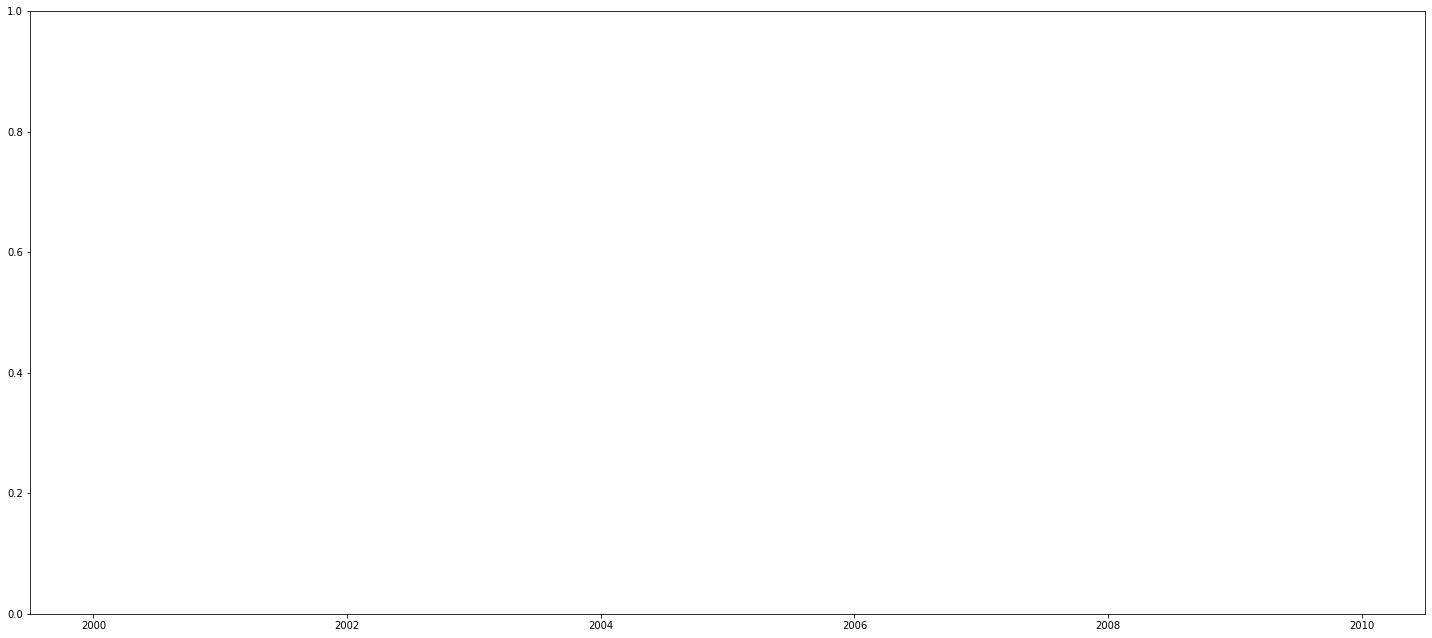

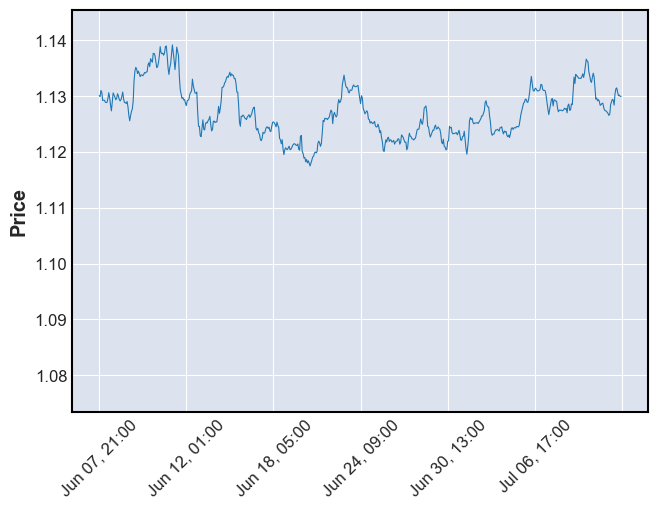

In [20]:
mpf.plot(picture, type='line')

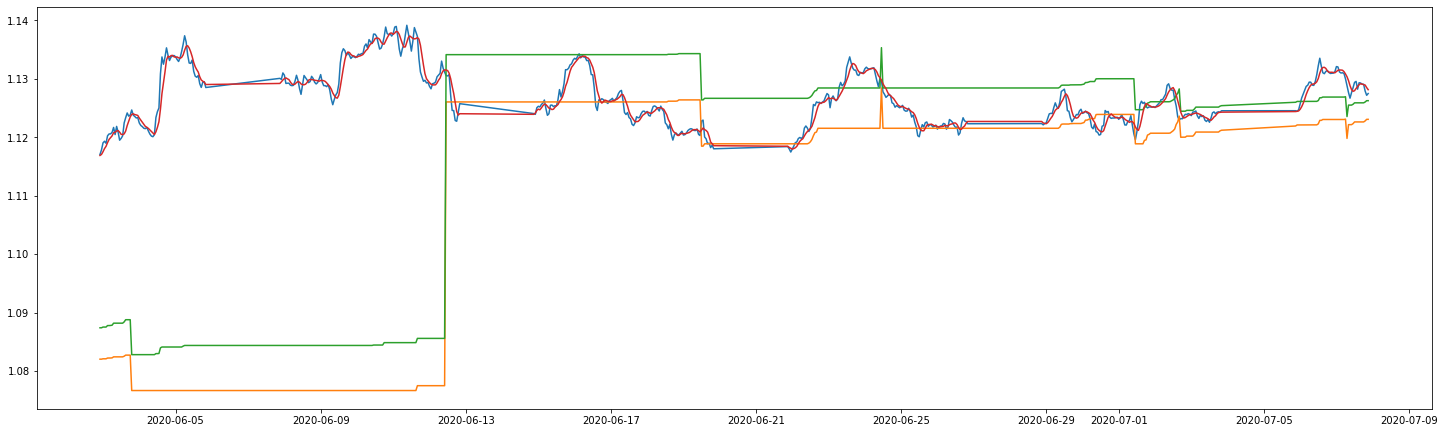

In [6]:
drawing_period = period*-1
drawing = final.iloc[drawing_period:,:]

#drawing = final.iloc[-10:,:]
#drawing
plt.figure(figsize=(25,10))
top = plt.subplot2grid((4,4),(0,0), rowspan=3, colspan=4)
picture = drawing.loc[:,['Close','Show_L','Show_H','M5']]
top.plot(picture.index, picture[['Close','Show_L','Show_H','M5']])

In [7]:
drawing.tail()

Time     Open     High  \
Date                                                                          
2020-07-07 17:00:00+00:00  2020-07-07T17:00:00.000000000Z  1.12904  1.14224   
2020-07-07 18:00:00+00:00  2020-07-07T18:00:00.000000000Z  1.12956  1.14224   
2020-07-07 19:00:00+00:00  2020-07-07T19:00:00.000000000Z  1.12861  1.14224   
2020-07-07 20:00:00+00:00  2020-07-07T20:00:00.000000000Z  1.12722  1.14224   
2020-07-07 21:00:00+00:00  2020-07-07T21:00:00.000000000Z  1.12767  1.14224   

                               Low     Close     Vol      Dev        M5  \
Date                                                                      
2020-07-07 17:00:00+00:00  1.11610  1.129100  3433.0  0.00108  1.129109   
2020-07-07 18:00:00+00:00  1.11610  1.129075  3439.0  0.00153  1.129009   
2020-07-07 19:00:00+00:00  1.11633  1.127920  2624.0  0.00152  1.128945   
2020-07-07 20:00:00+00:00  1.11669  1.127190  1135.0  0.00070  1.128515   
2020-07-07 21:00:00+00:00  1.11669  1.127490    52.0  0.00042  1.128155   

                                M20       M60  ...      Rat_5   Level_6  \
Date                                           ...                        
2020-07-07 17:00:00+00:00  1.129745  1.128039  ...  10.046790  1.135705   
2020-07-07 18:00:00+00:00  1.129649  1.128128  ...  10.046392  1.135705   
2020-07-07 19:00:00+00:00  1.129483  1.128200  ...   9.822970  1.135763   
2020-07-07 20:00:00+00:00  1.129237  1.128259  ...   9.947397  1.135852   
2020-07-07 21:00:00+00:00  1.129009  1.128335  ...   9.947454  1.135852   

                           Vol_6     Rat_6   Level_7  Vol_7     Rat_7  \
Date                                                                    
2020-07-07 17:00:00+00:00    0.0  7.669176  1.138972    0.0  0.379624   
2020-07-07 18:00:00+00:00    0.0  7.668871  1.138972    0.0  0.379609   
2020-07-07 19:00:00+00:00    0.0  7.728510  1.139001    0.0  0.323450   
2020-07-07 20:00:00+00:00    0.0  7.341573  1.139046    0.0  0.323456   
2020-07-07 21:00:00+00:00    0.0  7.341615  1.139046    0.0  0.323457   

                           Level_H    Show_L    Show_H  
Date                                                    
2020-07-07 17:00:00+00:00  1.14224  1.122635  1.125903  
2020-07-07 18:00:00+00:00  1.14224  1.122635  1.125903  
2020-07-07 19:00:00+00:00  1.14224  1.122807  1.126046  
2020-07-07 20:00:00+00:00  1.14224  1.123077  1.126271  
2020-07-07 21:00:00+00:00  1.14224  1.123077  1.126271  

[5 rows x 38 columns]

In [8]:
def running(period, win):
    first_step(win)
    calculating(period, bars=10)
    